In [1]:
# Exploratory Data Analysis (CPU-Bound)

# In this notebook I'll perform EDA to explain feature columns, 
# their relationships and overall everything we should know about the
# given dataset.

In [2]:
# Feature Columns

# time_ms = Timestamp of measurement in milliseconds

# cpu_psi_some_* = Shows how much time tasks are delayed because CPU is saturated. 

# cpu_psi_full_* = Percentage of time all non-idle tasks are stalled, waiting for CPU.  

# io_psi_some_* = Shows delay caused by storage / disk IO.

# io_psi_full_* = All runable tasks blocked on IO.

# mem_psi_some_* = Shows tasks waiting in memory.

# mem_psi_full_* = Shows all tasks stalled due to memory pressure.

# load_avg_* = Average number of runnable or IO-waiting tasks over time windows.

# procs_running = Number of processes currently runable.

# procs_blocked = Number of processes blocked waiting for IO completion.

# procs_disk_io = Processes specifically blocked on disk IO.

# Some -> At least 1 task waiting.
# Full -> Entire workload stalled.

In [ ]:
# Imports

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [4]:
# Read CSV files

PROJECT_ROOT = Path.cwd().parent.parent
DATASET_DIR = PROJECT_ROOT / "datasets"
PRIO_DIR = DATASET_DIR / "prio-cpu.csv"
RR_DIR = DATASET_DIR / "rr-cpu.csv"

df_prio = pd.read_csv(PRIO_DIR)
df_rr = pd.read_csv(RR_DIR)

# df_prio.head(5)
# df_rr.head(5)

In [5]:
# Add scheduler label
df_prio["scheduler"] = "PRIORITY"
df_rr["scheduler"] = "RR"

# Add ID for both
df_prio["id"] = df_prio.index + 1
df_rr["id"] = df_rr.index + 1

In [6]:
# Combine
df = pd.concat([df_prio, df_rr], ignore_index=True)

In [22]:
# Small check-up

df.head(5)

,time_ms,cpu_psi_some_10,cpu_psi_some_60,cpu_psi_some_300,load_avg_1,load_avg_5,load_avg_15,procs_running,procs_blocked,procs_disk_io,scheduler,id,cpu_stall_event
0,0,3.14,2.19,0.72,2.09,1.25,0.50,4,0,0,PRIORITY,1,False
1,1000,4.20,2.41,0.78,2.09,1.25,0.50,3,0,0,PRIORITY,2,False
2,2000,4.20,2.41,0.78,2.25,1.29,0.52,3,0,0,PRIORITY,3,False
3,3000,4.52,2.53,0.82,2.25,1.29,0.52,2,0,0,PRIORITY,4,False
4,4000,4.52,2.53,0.82,2.25,1.29,0.52,2,0,0,PRIORITY,5,False


In [ ]:
# Drop columns that have no information

for col in [
    "cpu_psi_full_10",
    "cpu_psi_full_60",
    "cpu_psi_full_300",
    "io_psi_some_10",
    "io_psi_some_60",
    "io_psi_some_300",
    "io_psi_full_10",
    "io_psi_full_60",
    "io_psi_full_300",
    "mem_psi_some_10",
    "mem_psi_some_60",
    "mem_psi_some_300",
    "mem_psi_full_10",
    "mem_psi_full_60",
    "mem_psi_full_300"
    ]:
    
    df = df.drop(col, axis=1)

In [9]:
# Basic Cleaning

# Sort by scheduler + time
df = df.sort_values(["scheduler", "time_ms"])

# Check missing
print(df.isna().sum())


time_ms             0
cpu_psi_some_10     0
cpu_psi_some_60     0
cpu_psi_some_300    0
load_avg_1          0
load_avg_5          0
load_avg_15         0
procs_running       0
procs_blocked       0
procs_disk_io       0
scheduler           0
id                  0
dtype: int64


In [16]:
# Summary stats per scheduler

metrics = [c for c in df.columns if not c in ["time_ms", "scheduler", "id"]]

summary = df.groupby("scheduler")[metrics].agg([
    "mean",
    "std",
    "median",
    # TODO Add quantiles to summary
    "max"
])

print(summary)

          cpu_psi_some_10                         cpu_psi_some_60            \
                     mean       std median    max            mean       std   
scheduler                                                                     
PRIORITY        16.584179  2.024765  16.31  21.44       15.698680  2.888478   
RR              15.830174  1.725423  15.88  19.70       15.481361  1.701262   

                        cpu_psi_some_300            ... procs_blocked      \
          median    max             mean       std  ...        median max   
scheduler                                           ...                     
PRIORITY   16.28  19.55        11.851580  4.292664  ...           0.0   2   
RR         15.87  17.20        15.828004  0.312363  ...           0.0   1   

          procs_disk_io                 cpu_stall_event                         
                   mean  std median max            mean       std median   max  
scheduler                                               

In [15]:
# Spike / Stall Detection

CPU_THRESHOLD = 5 # Adjustable

# TODO Map to different features to see how different schedulers behave.
df["cpu_stall_event"] = df["cpu_psi_some_10"] > CPU_THRESHOLD

# Event Frequency by Scheduler
stall_freq = df.groupby("scheduler")["cpu_stall_event"].mean()
print("CPU Stall Frequency: ")
print(stall_freq)

CPU Stall Frequency: 
scheduler
PRIORITY    0.994802
RR          0.991812
Name: cpu_stall_event, dtype: float64


In [17]:
# Spike / Stall Detection 2

def compute_event_durations(series):
    durations = []
    current = 0

    for val in series:
        if val:
            current += 1
        else:
            if current > 0:
                durations.append(current)
            current = 0

    if current > 0:
        durations.append(current)

    return durations

In [18]:
# Spike / Stall Detection 3

for sched in df["scheduler"].unique():
    s = df[df["scheduler"] == sched]["cpu_stall_event"]
    durations = compute_event_durations(s)
    
    print(f"Scheduler {sched} mean duration:", np.mean(durations) if durations else 0)
    # TODO This output means schedulers always stall. Up to Doğu to interpret.

Scheduler PRIORITY mean duration: 957.0
Scheduler RR mean duration: 969.0


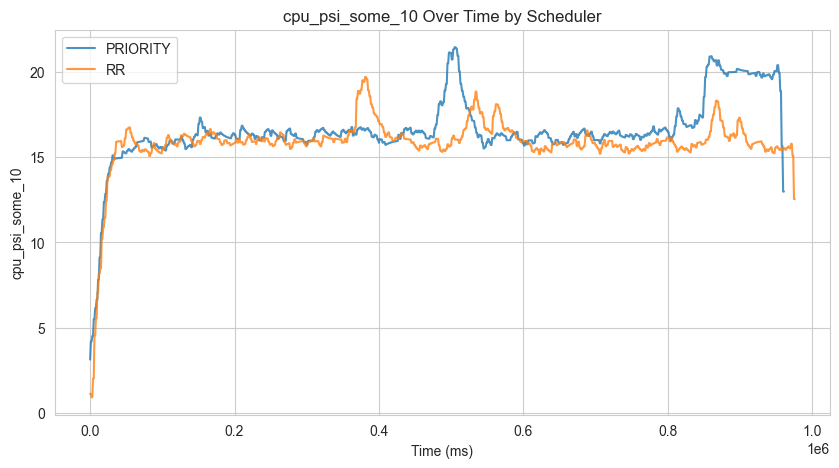

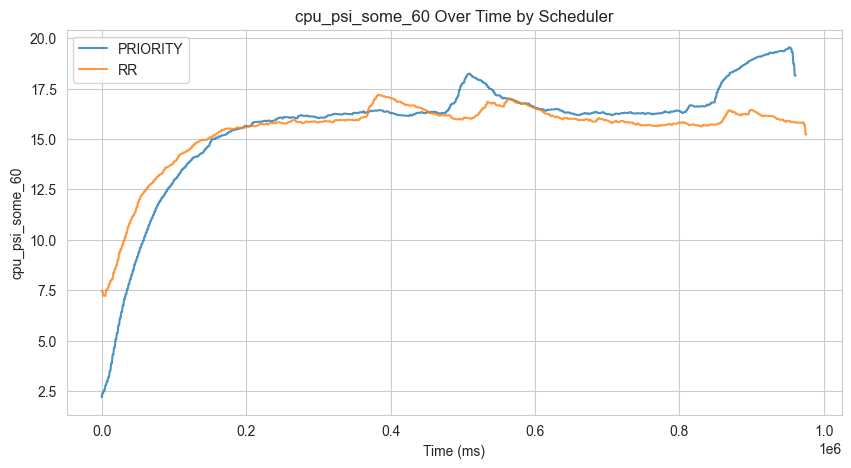

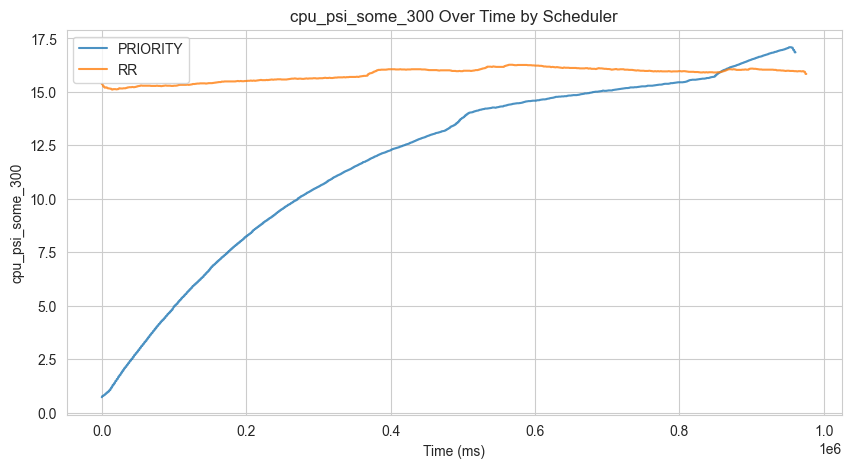

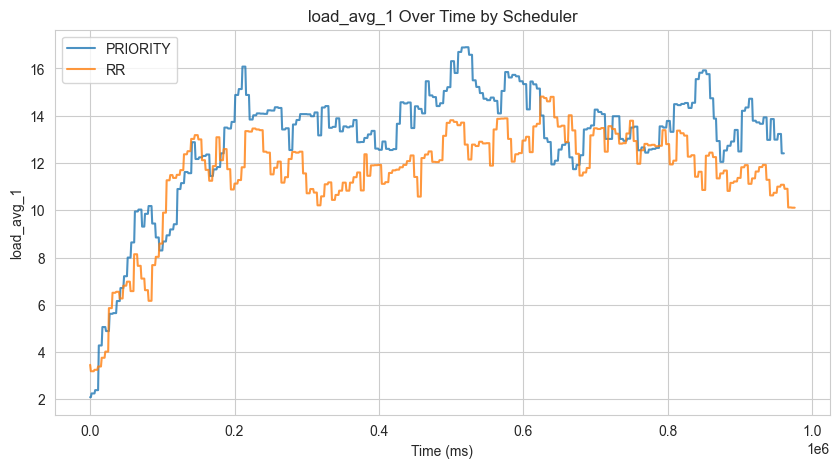

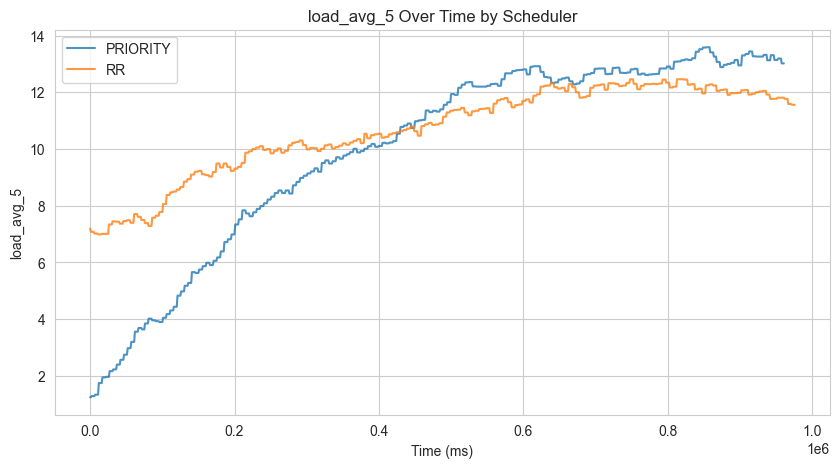

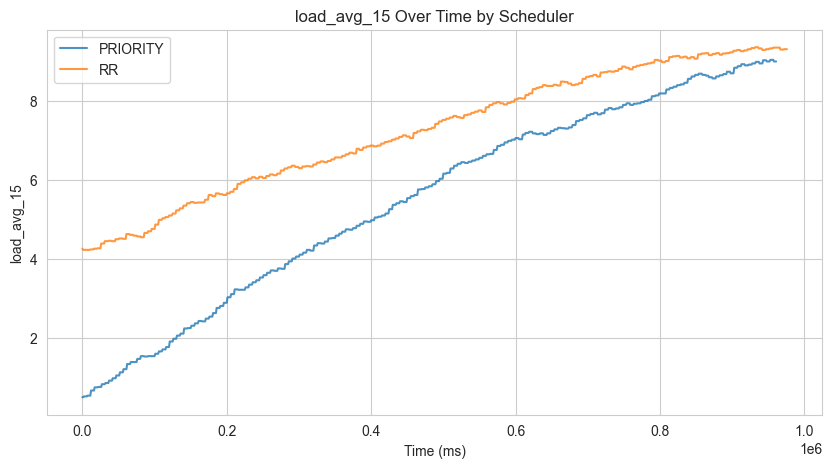

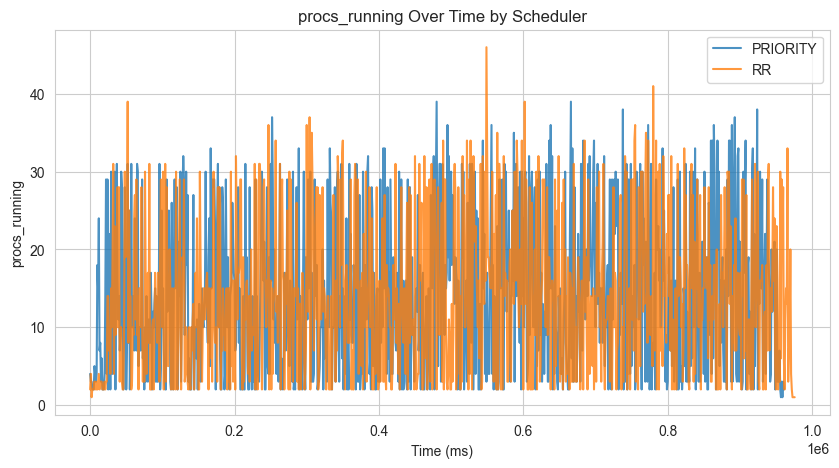

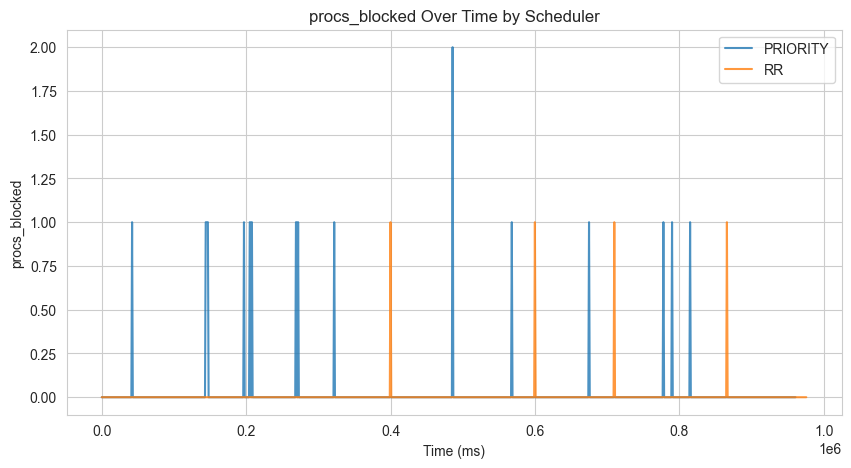

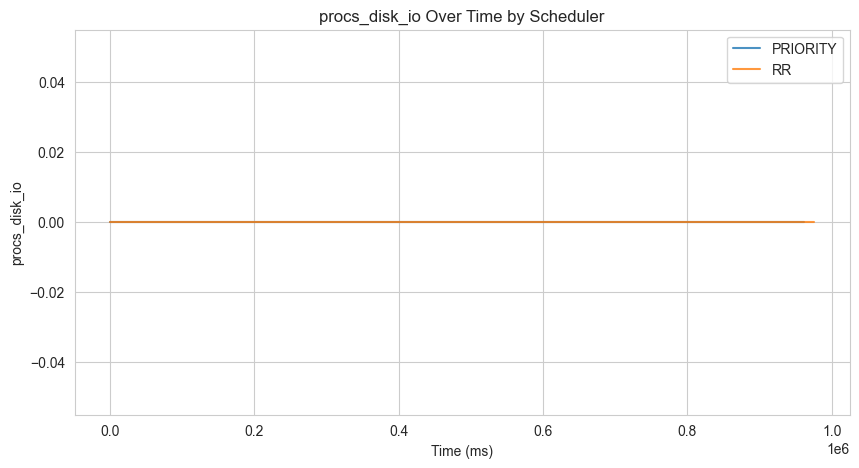

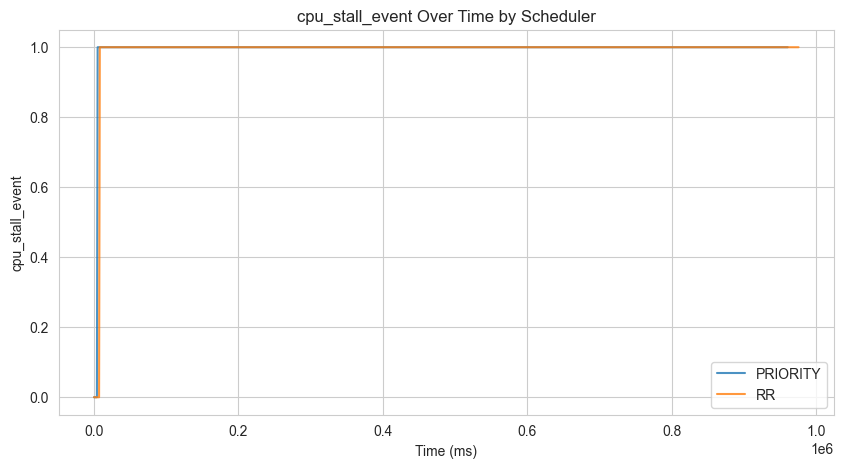

In [21]:
# Line graph of every metric with respect to time_ms

for col in metrics:
    plt.figure(figsize=(10,5))
    
    for sched in df["scheduler"].unique():
        sub = df[df["scheduler"] == sched]
        plt.plot(sub["time_ms"], sub[col], label=sched, alpha=0.8)
    
    plt.title(f"{col} Over Time by Scheduler")
    plt.xlabel("Time (ms)")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()